In [40]:
import sys
sys.path.append("../")

from utils import *
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import pickle
import os
from scipy.stats import gaussian_kde
from experiment import unpack_and_dequantize


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [41]:
def gini_coeff(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def mean_util(data):
    return np.mean(data)

def sen_welfare(data):
    return mean_util(data) * (1-gini_coeff(data))

In [42]:
for D in ["cpt", "nocpt"]:
    mean = []
    gini = []
    sen = []
    for f in tqdm(os.listdir("../" + D)):
        with open(os.path.join("../" + D, f), "rb") as f:
            res = pickle.load(f)
        wealth = unpack_and_dequantize(res["wealth"][:,-1], 200)
        health = unpack_and_dequantize(res["health"][:,-1], 200)
        util = utility(wealth, health, alpha=res['params']['alpha'])

        m = mean_util(util)
        g = gini_coeff(util)
        s = m * (1-g)

        mean.append(m)
        gini.append(g)
        sen.append(s)

    with open(f"../{D}_sen_welfare", "wb") as f:
        pickle.dump(sen, f)
    with open(f"../{D}_gini", "wb") as f:
        pickle.dump(gini, f)
    with open(f"../{D}_mean_util", "wb") as f:
        pickle.dump(mean, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

# CPT

In [46]:
directory = "../cpt"
with open(f"{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["lambduh"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

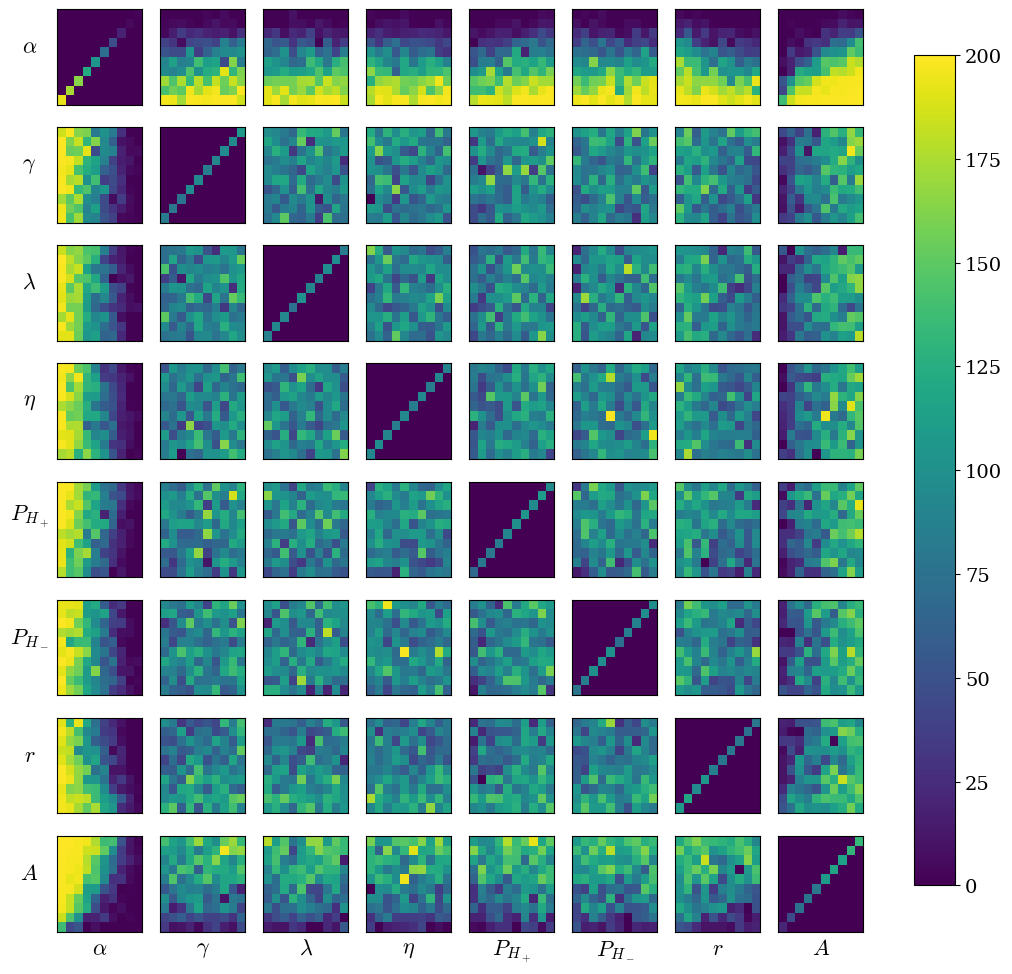

In [51]:
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95], [0.5,0.8], [1.5,3.0], [0.65, 0.95], [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]
S = np.array([d[-1] for d in data])

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 7:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

# NO-CPT

In [66]:
directory = "nocpt"
with open(f"../{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

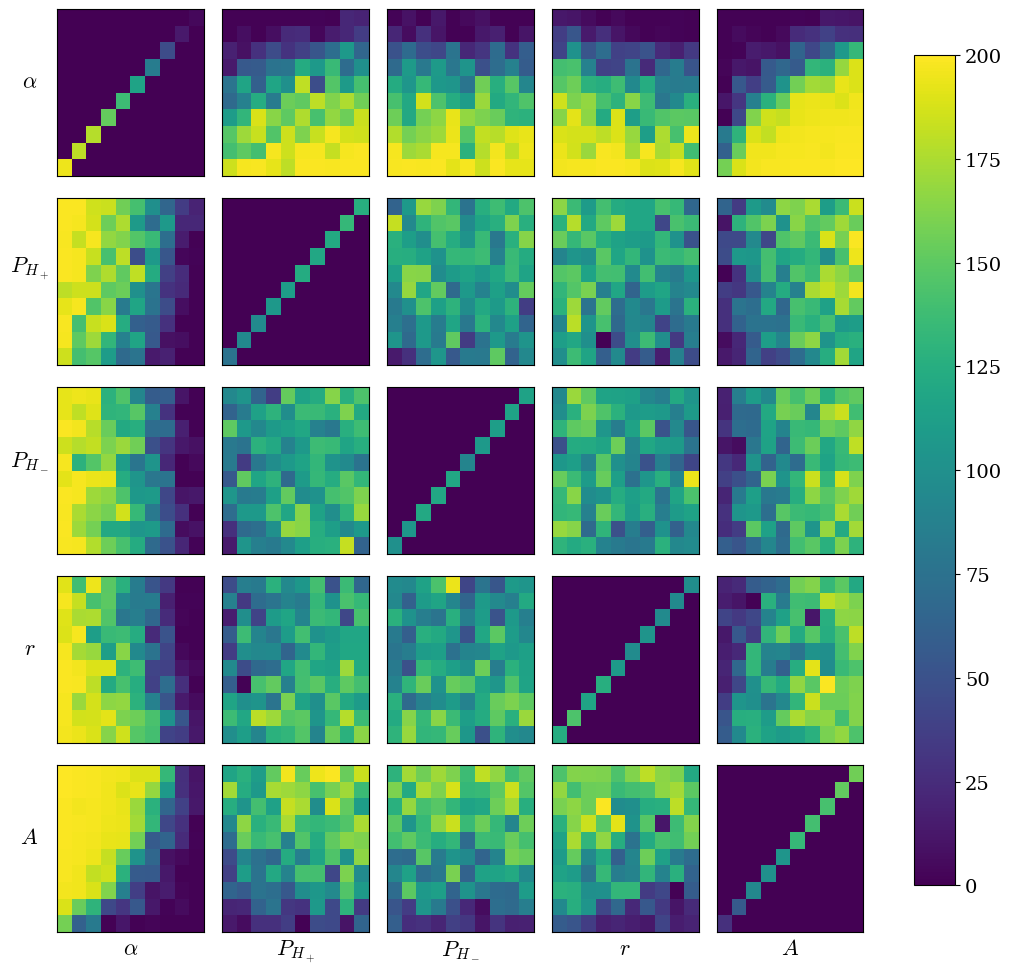

In [67]:
param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95],  [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]
S = np.array([d[-1] for d in data])

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

# KDEs

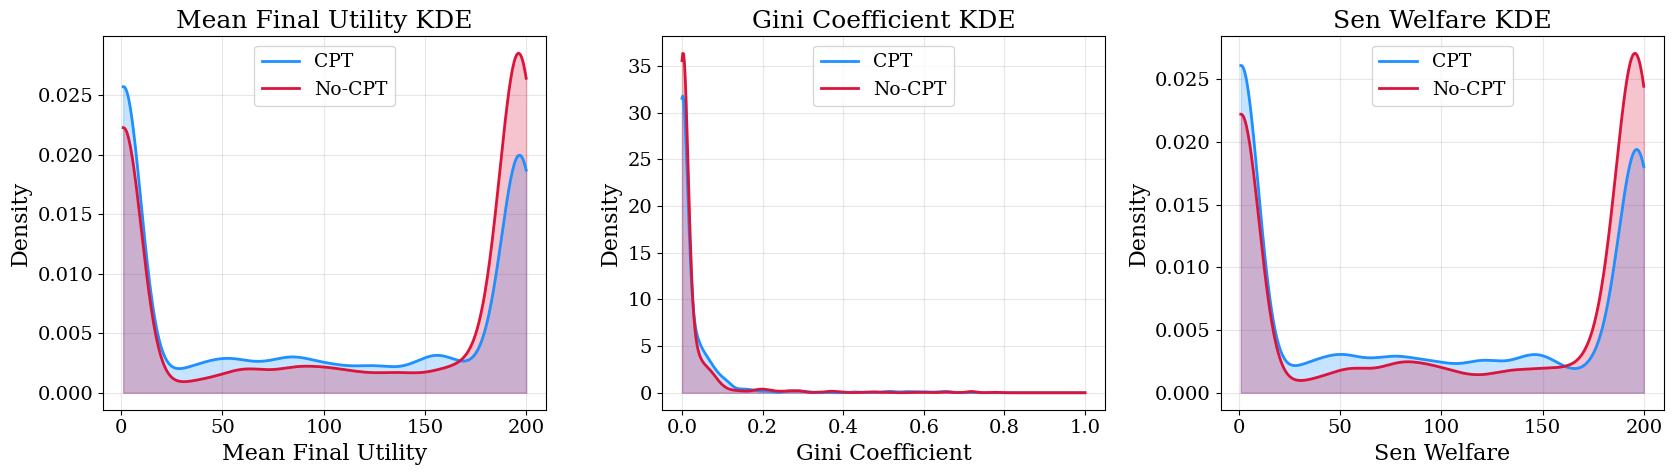

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))

# Sen Welfare
labels = ["CPT", "No-CPT"]
colors = ["dodgerblue", "crimson"]
for i, directory in enumerate(["../cpt", "../nocpt"]):
    with open(f"{directory}_sen_welfare", "rb") as f:
        sen = pickle.load(f)
    kde = gaussian_kde(sen, bw_method=0.1)
    x_vals = np.linspace(min(sen), max(sen), 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[2].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    axs[2].fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)
axs[2].set_xlabel("Sen Welfare")
axs[2].set_title("Sen Welfare KDE")
axs[2].set_ylabel("Density")
axs[2].legend(loc="upper center")
axs[2].grid()

# Gini Coefficient
for i, directory in enumerate(["../cpt", "../nocpt"]):
    with open(f"{directory}_gini", "rb") as f:
        G = pickle.load(f)
    kde = gaussian_kde(G, bw_method=0.15)
    x_vals = np.linspace(min(G), 1, 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[1].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    axs[1].fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)
axs[1].set_xlabel("Gini Coefficient")
axs[1].set_title("Gini Coefficient KDE")
axs[1].set_ylabel("Density")
axs[1].legend(loc="upper center")
axs[1].grid()

# Mean Final Utility
for i, directory in enumerate(["../cpt", "../nocpt"]):
    with open(f"{directory}_mean_util", "rb") as f:
        M = pickle.load(f)
    kde = gaussian_kde(M, bw_method=0.1)
    x_vals = np.linspace(min(M), max(M), 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[0].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    axs[0].fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)
axs[0].set_ylabel("Density")
axs[0].set_xlabel("Mean Final Utility")
axs[0].set_title("Mean Final Utility KDE")
axs[0].legend(loc="upper center")
axs[0].grid()

fig.tight_layout()
plt.show()